<a href="https://colab.research.google.com/github/desislava-tancheva/Projects/blob/main/Sound_Classification_with_CNN_on_Spectrograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
import skimage.io
 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D

# Sound Classification with a Convolutional Neural Network based on Spectrograms

### Introduction

The ability to classify sounds could be benefitial in many areas of our lives. It allows the monitoring of different aspects of the environment and can be used for things like reducing city noise, wildlife preservation, music production, maintenance of vechicles or detection of a child's cry.
 
The use of Convolutional Neural Networks (CNN) has been prevalent in the field of Computer vision and many state of the art models for image classification, object recognition or style transfer have been introduced. There are quite a few papers on sound analysis, it is however a much less researched topic.
 
Spectrograms are an obvious choice for approaching the issue of sound classification as it takes advantage of the effectivnes of CNNs and represents audio as an image. A spectrogram displays changes in the frequencies in a signal over time [1].

### Data preparation

**Data source: https://github.com/karolpiczak/ESC-50**


STAGE 1: Plotting and saving spectrograms from raw audio files (done in a previous Notebook)

STAGE 2: Loading the spectrograms and their labels in training, validation and testig set 

The dataset with audio files for this project called ESC10 comes from a larger dataset ESC50 [3] with 50 categories, only 10 of which will be used. 

The audio files come with structured metadata including columns with:
- filename - a combination of the information in all other columns
- fold - the fold each record belongs to (originally meant for 5-fold cross-validation) which will be used to easily split the data into train and test sets and ensures that the categories in each set are shuffled and balanced
- target - category in the form of integer in the range of [0, 49] that must be mapped to [0, 9]
- category - the category spelled out with words
- esc10 - a Boolean indicatior if the record belongs to the smaller ESC10 dataset that will be the dataset used for this project
- src_file - the original name of the file
- take - recording take A or B

In [ ]:
meta_data = pd.read_csv('/content/drive/MyDrive/ESC-50-master/meta/esc50.csv')
esc10 = meta_data[meta_data.esc10 == True] # Filtering the smaller dataset with 10 categories
esc10

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
14,1-110389-A-0.wav,1,0,dog,True,110389,A
24,1-116765-A-41.wav,1,41,chainsaw,True,116765,A
54,1-17150-A-12.wav,1,12,crackling_fire,True,17150,A
55,1-172649-A-40.wav,1,40,helicopter,True,172649,A
...,...,...,...,...,...,...,...
1876,5-233160-A-1.wav,5,1,rooster,True,233160,A
1888,5-234879-A-1.wav,5,1,rooster,True,234879,A
1889,5-234879-B-1.wav,5,1,rooster,True,234879,B
1894,5-235671-A-38.wav,5,38,clock_tick,True,235671,A


In [ ]:
category_map = {'chainsaw': 0, 'clock_tick': 1, 'crackling_fire': 2, 'crying_baby': 3,'dog': 4, 'helicopter': 5, 'rain': 6, 'rooster': 7, 'sea_waves': 8, 'sneezing': 9}
esc10.target = esc10.category.map(category_map) #remapping the target to range [0,9]
esc10

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,4,dog,True,100032,A
14,1-110389-A-0.wav,1,4,dog,True,110389,A
24,1-116765-A-41.wav,1,0,chainsaw,True,116765,A
54,1-17150-A-12.wav,1,2,crackling_fire,True,17150,A
55,1-172649-A-40.wav,1,5,helicopter,True,172649,A
...,...,...,...,...,...,...,...
1876,5-233160-A-1.wav,5,7,rooster,True,233160,A
1888,5-234879-A-1.wav,5,7,rooster,True,234879,A
1889,5-234879-B-1.wav,5,7,rooster,True,234879,B
1894,5-235671-A-38.wav,5,1,clock_tick,True,235671,A


In [ ]:
esc10.loc[:, 'filepath'] = '/content/drive/MyDrive/Specgrams/' # adding the filepath for easier loading of files later
esc10.loc[:,'filename'] = esc10.filename.str.replace('.wav', '.png') # changing the file extention in the table, because we will load spectograms in .png format
esc10.loc[:,'files'] = esc10.filepath + esc10.filename
esc10 = esc10[['files', 'category', 'fold', 'target']]
esc10

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,files,category,fold,target
0,/content/drive/MyDrive/Specgrams/1-100032-A-0.png,dog,1,4
14,/content/drive/MyDrive/Specgrams/1-110389-A-0.png,dog,1,4
24,/content/drive/MyDrive/Specgrams/1-116765-A-41...,chainsaw,1,0
54,/content/drive/MyDrive/Specgrams/1-17150-A-12.png,crackling_fire,1,2
55,/content/drive/MyDrive/Specgrams/1-172649-A-40...,helicopter,1,5
...,...,...,...,...
1876,/content/drive/MyDrive/Specgrams/5-233160-A-1.png,rooster,5,7
1888,/content/drive/MyDrive/Specgrams/5-234879-A-1.png,rooster,5,7
1889,/content/drive/MyDrive/Specgrams/5-234879-B-1.png,rooster,5,7
1894,/content/drive/MyDrive/Specgrams/5-235671-A-38...,clock_tick,5,1


Let's check the count of examples per category and what the 5 folds contain:

In [ ]:
esc10.category.value_counts()

rooster           40
clock_tick        40
rain              40
helicopter        40
chainsaw          40
sea_waves         40
sneezing          40
crackling_fire    40
dog               40
crying_baby       40
Name: category, dtype: int64

In [ ]:
esc10.fold.value_counts()

5    80
4    80
3    80
2    80
1    80
Name: fold, dtype: int64

The 400 images are split into 5 equally sized folds. 4 of them will be used for training and 1 split for validation and testing.

In [ ]:
train_df = esc10[esc10.fold != 5]
val_test_df = esc10[esc10.fold == 5].sort_values('category')

In [ ]:
val_df = pd.DataFrame()
test_df = pd.DataFrame()
for row in range(1, len(val_test_df) + 1, 2): 
  val_df = val_df.append(val_test_df[row:row + 1])
for row in range(2, len(val_test_df) + 1, 2): 
  test_df = val_df.append(val_test_df[row:row + 1])


Let's see if the splitting was successful in terms of correctly stratifying the categories. 

In [ ]:
train_df.category.value_counts()

chainsaw          32
rooster           32
sea_waves         32
sneezing          32
clock_tick        32
rain              32
crackling_fire    32
helicopter        32
dog               32
crying_baby       32
Name: category, dtype: int64

In [ ]:
val_df.category.value_counts()

sneezing          4
chainsaw          4
clock_tick        4
rain              4
sea_waves         4
crackling_fire    4
helicopter        4
dog               4
crying_baby       4
rooster           4
Name: category, dtype: int64

In [ ]:

test_df.category.value_counts()

sneezing          4
chainsaw          4
clock_tick        4
rain              4
sea_waves         4
crackling_fire    4
helicopter        4
dog               4
crying_baby       4
rooster           4
Name: category, dtype: int64

Final step is to read the images into a dataset and create the array of labels that will be later fed to the CNN.

In [ ]:
train_dataset = []

for i in train_df.files.values:
  train_dataset.append(skimage.io.imread(i))

x_train = np.array(train_dataset)
x_train = x_train / 255.0 # Normalization 
x_train.shape

(320, 217, 334, 4)

In [ ]:
y_train = np.array(train_df.target)
y_train.shape

(320,)

In [ ]:
val_dataset = []

for i in val_df.files.values:
  val_dataset.append(skimage.io.imread(i))

x_val = np.array(val_dataset)
x_val = x_val / 255.0 # Normalization 
x_val.shape

(40, 217, 334, 4)

In [ ]:
y_val = np.array(val_df.target)
y_val.shape

(40,)

Now the constants for input and output shape can be introduced.

In [ ]:
INPUT_SIZE = (217, 334, 4)
NUM_CLASSES = 10

### Visualizing the data

Here you can get a feeling of how some of the represented in the dataset sounds look like when visualized. This is a particularly mesmerizing step. It is easy to notice, that a person will be able to tell apart the different spectrograms and what sound they come from after staring long enough, but will the model be able to as well?

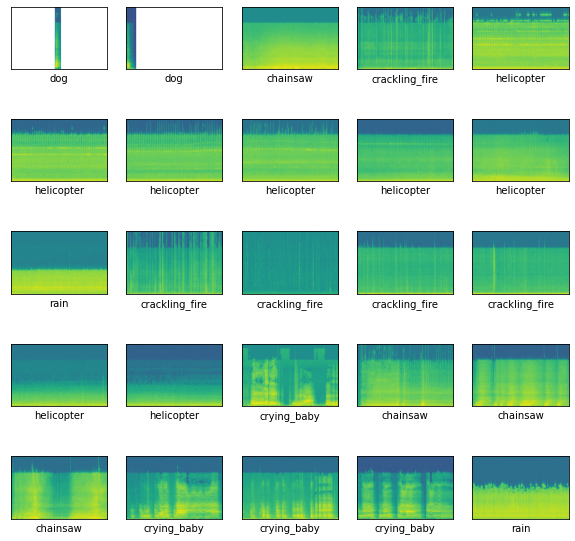

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(np.array(train_df.category)[i])
plt.show()

### Building the CNN

The approach for building and improving the CNN architecture adopted in this prject will be to train a baseline model, propose an original one and try to improve the one that outperforms the other. 

The baseline model architecture is taken from a research paper [2], which deals with the same topic and uses the ESC10 and ESC50 datasetas well. We'll find out if it's score can be improved in the next sections.

In [ ]:
# Hyperparameters
BATCH_SIZE = 32 # standard, appropriate for small datasets
EPOCHS = 30 

#### Baseline model

In [ ]:
paper_model = Sequential([
                          Input(INPUT_SIZE),
                          Conv2D(32, (3, 3), activation = 'relu'),
                          MaxPool2D((2, 2)),
                          Conv2D(64, (3, 3), activation = 'relu'),
                          MaxPool2D((2, 2)),
                          Dropout(0.5), 
                          Flatten(),
                          Dense(128, activation = 'relu') ,
                          Dense(10, activation = 'softmax')
])

paper_model.compile(optimizer='rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
paper_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 215, 332, 32)      1184      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 107, 166, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 105, 164, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 52, 82, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 52, 82, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 272896)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [ ]:
hist1 = paper_model.fit(x_train, y_train, epochs = 30, batch_size = BATCH_SIZE, validation_data = (x_val, y_val))

Epoch 1/30
10/10 [==============================] - 35s 3s/step - loss: 23.9098 - acc: 0.1172 - val_loss: 1.8272 - val_acc: 0.3500
Epoch 2/30
10/10 [==============================] - 32s 3s/step - loss: 2.0682 - acc: 0.2601 - val_loss: 2.2340 - val_acc: 0.2750
Epoch 3/30
10/10 [==============================] - 32s 3s/step - loss: 1.9293 - acc: 0.2821 - val_loss: 1.6641 - val_acc: 0.4250
Epoch 4/30
10/10 [==============================] - 34s 3s/step - loss: 1.6532 - acc: 0.3728 - val_loss: 1.6619 - val_acc: 0.3750
Epoch 5/30
10/10 [==============================] - 33s 3s/step - loss: 1.6217 - acc: 0.3579 - val_loss: 1.3862 - val_acc: 0.4750
Epoch 6/30
10/10 [==============================] - 33s 3s/step - loss: 1.3503 - acc: 0.5676 - val_loss: 1.5772 - val_acc: 0.3500
Epoch 7/30
10/10 [==============================] - 32s 3s/step - loss: 1.4231 - acc: 0.4683 - val_loss: 1.3493 - val_acc: 0.4750
Epoch 8/30
10/10 [==============================] - 32s 3s/step - loss: 1.2679 - acc: 0.4

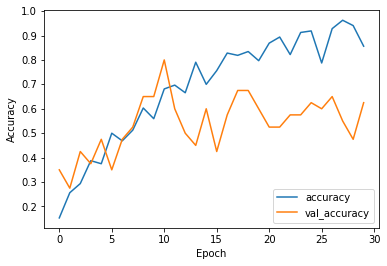

In [ ]:
plt.plot(hist1.history['acc'], label='accuracy')
plt.plot(hist1.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

The model overfits the data for 30 epochs and has a considerable gap between train and validation accuracy.

#### Proposition of  a new model

In [ ]:
proposed_model = Sequential([
                       Input(shape = INPUT_SIZE), 
                       Conv2D(64, kernel_size = (3,3), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Conv2D(16, kernel_size = (3,3), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Dropout(0.3),
                       Flatten(),
                       Dense(64, activation = 'relu'),
                       Dense(16, activation = 'relu'),
                       Dense(10, activation = 'softmax')           
])

proposed_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
proposed_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 215, 332, 64)      2368      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 108, 166, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 164, 16)      9232      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 53, 82, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 82, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 69536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [ ]:
hist2 = proposed_model.fit(x_train, y_train, epochs = 30, batch_size = BATCH_SIZE, validation_data = (x_val, y_val))

Epoch 1/30
10/10 [==============================] - 36s 4s/step - loss: 2.0144 - accuracy: 0.2375 - val_loss: 2.0081 - val_accuracy: 0.2500
Epoch 2/30
10/10 [==============================] - 36s 4s/step - loss: 1.9456 - accuracy: 0.2469 - val_loss: 1.9113 - val_accuracy: 0.3000
Epoch 3/30
10/10 [==============================] - 37s 4s/step - loss: 1.8436 - accuracy: 0.2750 - val_loss: 1.7524 - val_accuracy: 0.3250
Epoch 4/30
10/10 [==============================] - 36s 4s/step - loss: 1.7548 - accuracy: 0.3125 - val_loss: 1.7574 - val_accuracy: 0.3750
Epoch 5/30
10/10 [==============================] - 35s 3s/step - loss: 1.6407 - accuracy: 0.3562 - val_loss: 1.8980 - val_accuracy: 0.3000
Epoch 6/30
10/10 [==============================] - 35s 3s/step - loss: 1.6271 - accuracy: 0.3219 - val_loss: 1.5815 - val_accuracy: 0.4750
Epoch 7/30
10/10 [==============================] - 36s 4s/step - loss: 1.4582 - accuracy: 0.4187 - val_loss: 1.4669 - val_accuracy: 0.4750
Epoch 8/30
10/10 [==

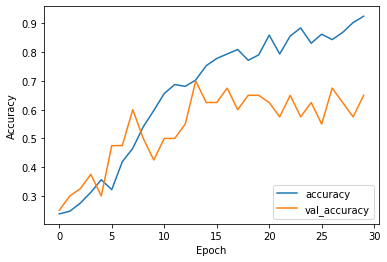

In [ ]:
plt.plot(hist2.history['accuracy'], label='accuracy')
plt.plot(hist2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

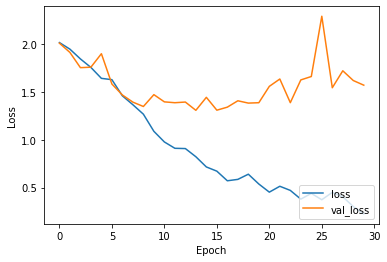

In [ ]:
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

#### Tuning and Improvement

Steps that can be taken towards an improved score and prevention of overfitting can be additional regularization techniques and hyperparameter tuning.

Regularization can be achieved with Dropout, L1 & L2 pentalties and Early Stopping, while some meaningful parameters to tune are Kernel Size, NN Architecture, Optimizers and Loss function, Batch size and epochs and activation functions [4]. A combination of those tecniques will be applied to the next few models with the hope of better scores. However, main problem of this project is the scarcity of data that can hardlty be overcome with just tuning.

In [ ]:
from tensorflow.keras.regularizers import l1_l2

In [ ]:
proposed_model_with_regularization = Sequential([
                       Input(shape = INPUT_SIZE), 
                       Conv2D(64, kernel_size = (3,3), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Conv2D(16, kernel_size = (3,3), activation = 'relu', activity_regularizer = l1_l2(l1=1e-5, l2=1e-4)),
                       MaxPool2D(2, padding='same'),
                       Dropout(0.3),
                       Flatten(),
                       Dense(64, activation = 'relu'),
                       Dense(16, activation = 'relu'),
                       Dense(10, activation = 'softmax')           
])

proposed_model_with_regularization.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
proposed_model_with_regularization.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 215, 332, 64)      2368      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 108, 166, 64)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 106, 164, 16)      9232      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 82, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 53, 82, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 69536)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

In [ ]:
hist5 = proposed_model_with_regularization.fit(x_train, y_train, epochs = 30, batch_size = BATCH_SIZE, validation_data = (x_val, y_val))

Epoch 1/30
10/10 [==============================] - 39s 4s/step - loss: 2.7798 - accuracy: 0.1380 - val_loss: 2.1463 - val_accuracy: 0.2500
Epoch 2/30
10/10 [==============================] - 36s 4s/step - loss: 2.1302 - accuracy: 0.1990 - val_loss: 2.1645 - val_accuracy: 0.2500
Epoch 3/30
10/10 [==============================] - 36s 4s/step - loss: 2.0867 - accuracy: 0.2225 - val_loss: 1.9156 - val_accuracy: 0.4000
Epoch 4/30
10/10 [==============================] - 36s 4s/step - loss: 1.9849 - accuracy: 0.2727 - val_loss: 1.8268 - val_accuracy: 0.3500
Epoch 5/30
10/10 [==============================] - 36s 4s/step - loss: 1.9570 - accuracy: 0.2734 - val_loss: 1.7955 - val_accuracy: 0.4500
Epoch 6/30
10/10 [==============================] - 36s 4s/step - loss: 1.7757 - accuracy: 0.4433 - val_loss: 1.7488 - val_accuracy: 0.3500
Epoch 7/30
10/10 [==============================] - 36s 4s/step - loss: 1.7385 - accuracy: 0.3855 - val_loss: 1.6924 - val_accuracy: 0.4000
Epoch 8/30
10/10 [==

Let's try EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
proposed_model_with_stopping = Sequential([
                       Input(shape = INPUT_SIZE), 
                       Conv2D(64, kernel_size = (3,3), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Conv2D(16, kernel_size = (3,3), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Dropout(0.3),
                       Flatten(),
                       Dense(64, activation = 'relu'),
                       Dense(16, activation = 'relu'),
                       Dense(10, activation = 'softmax')           
])
callbacks = EarlyStopping(monitor = 'val_loss', min_delta=0, patience=5, restore_best_weights = True)
proposed_model_with_stopping.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
proposed_model_with_stopping.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 215, 332, 64)      2368      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 108, 166, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 106, 164, 16)      9232      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 53, 82, 16)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 53, 82, 16)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 69536)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)               

In [ ]:
hist6 = proposed_model_with_stopping.fit(x_train, y_train, epochs = 30, batch_size = BATCH_SIZE, validation_data = (x_val, y_val), callbacks = callbacks)

Epoch 1/30
10/10 [==============================] - 37s 4s/step - loss: 2.8224 - accuracy: 0.1172 - val_loss: 2.1862 - val_accuracy: 0.2250
Epoch 2/30
10/10 [==============================] - 37s 4s/step - loss: 2.1918 - accuracy: 0.1571 - val_loss: 2.0639 - val_accuracy: 0.2500
Epoch 3/30
10/10 [==============================] - 37s 4s/step - loss: 2.1244 - accuracy: 0.2119 - val_loss: 2.0778 - val_accuracy: 0.2500
Epoch 4/30
10/10 [==============================] - 36s 4s/step - loss: 2.0957 - accuracy: 0.2185 - val_loss: 2.2122 - val_accuracy: 0.2250
Epoch 5/30
10/10 [==============================] - 37s 4s/step - loss: 2.1356 - accuracy: 0.2122 - val_loss: 2.0724 - val_accuracy: 0.2250
Epoch 6/30
10/10 [==============================] - 37s 4s/step - loss: 2.0586 - accuracy: 0.2143 - val_loss: 2.0968 - val_accuracy: 0.1750
Epoch 7/30
10/10 [==============================] - 36s 4s/step - loss: 2.0100 - accuracy: 0.2344 - val_loss: 2.1159 - val_accuracy: 0.2250


Bigger Kernel size

In [ ]:
proposed_model_with_bigger_kernel = Sequential([
                       Input(shape = INPUT_SIZE), 
                       Conv2D(64, kernel_size = (5,5), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Conv2D(16, kernel_size = (5,5), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Dropout(0.3),
                       Flatten(),
                       Dense(64, activation = 'relu'),
                       Dense(16, activation = 'relu'),
                       Dense(10, activation = 'softmax')           
])

proposed_model_with_bigger_kernel.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
proposed_model_with_bigger_kernel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 213, 330, 64)      6464      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 107, 165, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 103, 161, 16)      25616     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 52, 81, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 52, 81, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 67392)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [ ]:
hist7 = proposed_model_with_bigger_kernel.fit(x_train, y_train, epochs = 30, batch_size = BATCH_SIZE, validation_data = (x_val, y_val))

Epoch 1/30
10/10 [==============================] - 82s 8s/step - loss: 2.5174 - accuracy: 0.1082 - val_loss: 2.2391 - val_accuracy: 0.1000
Epoch 2/30
10/10 [==============================] - 79s 8s/step - loss: 2.2374 - accuracy: 0.1659 - val_loss: 2.1961 - val_accuracy: 0.1750
Epoch 3/30
10/10 [==============================] - 79s 8s/step - loss: 2.2247 - accuracy: 0.1891 - val_loss: 2.2062 - val_accuracy: 0.1500
Epoch 4/30
10/10 [==============================] - 80s 8s/step - loss: 2.1810 - accuracy: 0.1613 - val_loss: 2.0769 - val_accuracy: 0.2750
Epoch 5/30
10/10 [==============================] - 79s 8s/step - loss: 2.0226 - accuracy: 0.2558 - val_loss: 2.1413 - val_accuracy: 0.2250
Epoch 6/30
10/10 [==============================] - 79s 8s/step - loss: 2.0343 - accuracy: 0.2325 - val_loss: 2.0152 - val_accuracy: 0.2750
Epoch 7/30
10/10 [==============================] - 79s 8s/step - loss: 1.8599 - accuracy: 0.2960 - val_loss: 2.0104 - val_accuracy: 0.2500
Epoch 8/30
10/10 [==

In [ ]:
tuned_proposed_model = Sequential([
                       Input(shape = INPUT_SIZE), 
                       Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Conv2D(64, kernel_size = (3,3), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Conv2D(16, kernel_size = (3,3), activation = 'relu'),
                       MaxPool2D(2, padding='same'),
                       Dropout(0.5),
                       Flatten(),
                       Dense(64, activation = 'relu'),
                       Dense(16, activation = 'relu'),
                       Dense(10, activation = 'softmax')           
])

tuned_proposed_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
tuned_proposed_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 215, 332, 128)     4736      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 108, 166, 128)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 106, 164, 64)      73792     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 53, 82, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 51, 80, 16)        9232      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 40, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 26, 40, 16)       

In [ ]:
hist3 = tuned_proposed_model.fit(x_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = (x_val, y_val))

Epoch 1/30
10/10 [==============================] - 106s 10s/step - loss: 2.2856 - accuracy: 0.1297 - val_loss: 2.1745 - val_accuracy: 0.1750
Epoch 2/30
10/10 [==============================] - 103s 10s/step - loss: 2.1267 - accuracy: 0.1996 - val_loss: 1.9832 - val_accuracy: 0.3250
Epoch 3/30
10/10 [==============================] - 103s 10s/step - loss: 2.0555 - accuracy: 0.3031 - val_loss: 1.8577 - val_accuracy: 0.3000
Epoch 4/30
10/10 [==============================] - 103s 10s/step - loss: 1.9228 - accuracy: 0.3982 - val_loss: 1.9152 - val_accuracy: 0.3500
Epoch 5/30
10/10 [==============================] - 103s 10s/step - loss: 1.7981 - accuracy: 0.3600 - val_loss: 1.5866 - val_accuracy: 0.4750
Epoch 6/30
10/10 [==============================] - 103s 10s/step - loss: 1.6404 - accuracy: 0.3973 - val_loss: 1.5084 - val_accuracy: 0.4500
Epoch 7/30
10/10 [==============================] - 103s 10s/step - loss: 1.5228 - accuracy: 0.4852 - val_loss: 1.3651 - val_accuracy: 0.5250
Epoch 

Lastly, I will try a model proposed in a Kaggle Notebook [5] to see if the results will somewhat improve.

In [ ]:
model7 = Sequential([
                          Conv2D(16, (3,3), padding= 'same', activation='relu', input_shape=(217, 334, 4)),
                          MaxPool2D(2, padding='same'),  
                          Conv2D(32, (3,3), padding= 'same', activation='relu'),
                          MaxPool2D(2, padding='same'),
                          Dropout(0.3),
                          Conv2D(64, (3,3), padding= 'same', activation='relu'),
                          MaxPool2D(2, padding='same'),
                          Dropout(0.3),
                          Conv2D(128, (3,3),padding='same', activation = 'relu'),
                          MaxPool2D(2 ,padding='same'),
                          Dropout(0.3),
                          GlobalAveragePooling2D(),
                          Dense(10, activation='softmax')  
                                ])
model7.compile(loss= 'sparse_categorical_crossentropy', optimizer = 'adam', metrics= ['accuracy'])
model7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 217, 334, 16)      592       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 109, 167, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 167, 32)      4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 55, 84, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 55, 84, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 55, 84, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 28, 42, 64)       

In [ ]:
hist = model7.fit(x_train, y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data=(x_val, y_val))

Epoch 1/30
10/10 [==============================] - 27s 3s/step - loss: 1.6945 - accuracy: 0.3344 - val_loss: 1.5665 - val_accuracy: 0.4250
Epoch 2/30
10/10 [==============================] - 26s 3s/step - loss: 1.6668 - accuracy: 0.3281 - val_loss: 1.5748 - val_accuracy: 0.3750
Epoch 3/30
10/10 [==============================] - 27s 3s/step - loss: 1.6629 - accuracy: 0.3406 - val_loss: 1.5227 - val_accuracy: 0.3750
Epoch 4/30
10/10 [==============================] - 27s 3s/step - loss: 1.6408 - accuracy: 0.3313 - val_loss: 1.5349 - val_accuracy: 0.4000
Epoch 5/30
10/10 [==============================] - 27s 3s/step - loss: 1.5998 - accuracy: 0.3406 - val_loss: 1.4885 - val_accuracy: 0.4250
Epoch 6/30
10/10 [==============================] - 26s 3s/step - loss: 1.5675 - accuracy: 0.3781 - val_loss: 1.4656 - val_accuracy: 0.4250
Epoch 7/30
10/10 [==============================] - 27s 3s/step - loss: 1.5504 - accuracy: 0.4156 - val_loss: 1.4551 - val_accuracy: 0.5250
Epoch 8/30
10/10 [==

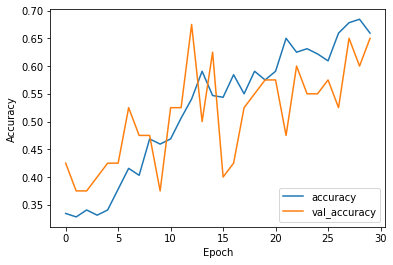

In [ ]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

It is obvious that the models are not performing all too well and the they severely overfit the training data, but that is to be expected with such a small sample size. However, the overall approach seems promising for the task of sound classification and further steps that can be taken for better accuracy is finding more labaled audio files, data augmentation or transfer learning.

### References

[1] 2020, "Understanding Spectrograms", << https://www.izotope.com/en/learn/understanding-spectrograms.html >>

[2] Khamparia, A., Gupta, D., Nguyen, N., Khanna, A., Pandey, B., & Tiwari, P., 2019, "Sound Classification Using Convolutional Neural
Network and Tensor Deep Stacking Network"

[3] K. J. Piczak. 2015, "ESC: Dataset for Environmental Sound Classification". Proceedings of the 23rd Annual ACM Conference on Multimedia, Brisbane, Australia

[4] Gandhi, R., 2018, "Improving the Performance of a Neural Network", << https://towardsdatascience.com/how-to-increase-the-accuracy-of-a-neural-network-9f5d1c6f407d >>

[5] Dobariya, n., 2020, "Basic approach to audio classification" << https://www.kaggle.com/doofensmirtz/basic-approach-to-audio-classification >>